In [109]:
library(repr)
library(tidyverse)
library(tidymodels)
library(readr)
library(janitor)
library(dplyr)
library(cowplot)

options(digits = 4)
set.seed(2)

#### Group project proposal

# Data Analysis on Air Quality Index of Counties in the US

DSCI100 group porject-006-14  
Group member:  
`Dorthy GER`  
`Charlie Hua`  
`Callie Phelps`  
`Hancheng Zhang 29643160`


## Introduction

## Preliminary exploratory data analysis

This data analysis project is based on the "annual_aqi_by_county_2021.csv" dataset. It can be directly read from the web as follow.

In [56]:
url <- "https://raw.githubusercontent.com/Hansen0014/Air-quality-data/main/annual_aqi_by_county_2021.csv"
Air_quality <- read.csv(url)
head(Air_quality)

,State,County,Year,Days.with.AQI,Good.Days,Moderate.Days,Unhealthy.for.Sensitive.Groups.Days,Unhealthy.Days,Very.Unhealthy.Days,Hazardous.Days,Max.AQI,X90th.Percentile.AQI,Median.AQI,Days.CO,Days.NO2,Days.Ozone,Days.SO2,Days.PM2.5,Days.PM10
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,Alabama,Baldwin,2021,203,190,13,0,0,0,0,61,49,37,0,0,166,0,37,0
2,Alabama,Clay,2021,73,66,7,0,0,0,0,67,50,28,0,0,0,0,73,0
3,Alabama,DeKalb,2021,239,211,28,0,0,0,0,84,51,38,0,0,213,0,26,0
4,Alabama,Elmore,2021,180,177,3,0,0,0,0,87,45,34,0,0,180,0,0,0
5,Alabama,Etowah,2021,204,178,26,0,0,0,0,77,54,38,0,0,158,0,46,0
6,Alabama,Jefferson,2021,182,90,90,1,0,1,0,213,74,51,2,1,65,0,113,1


Since we want to predict does a county face existing/potential air quality issues. We decide to set a bar towards `90th_Percentile_AQI`. Counties with 90th percentile AQI **higher than or equal to 60** would be defined as "`not satisfying`" type(having existing/potential air quality), and counties with 90th percentile AQI **lower than 60** would be defined as `satisfying` type(having no air quality issue).

In order to achieve this goal, we need to wangle this data to a clean and tidy form without other unnecessary columns.  
Firstly, we chosed "`days_Ozone`","`good_days`","`days_pm2.5`" as our **predictor variable**.  
Due to these three variable are based on "`Days_with_AQI`", we can not directly use them as comparison variable since every county has different `Days_with_AQI`. So we mutated them to the percentage form.  
Then we divided the observations to two groups---"`not satisfying`" and "`satisifying`" based on their "`90th_Percentile_AQI`".

In [70]:
Air_quality_cleaned <- Air_quality%>%
                clean_names()%>%
                mutate(per_days_Ozone = 100*days_ozone/days_with_aqi, per_days_PM2.5 = 100*days_pm2_5/days_with_aqi, 
                       per_good_days = 100*good_days/days_with_aqi, 
                       air_quality_type = case_when(x90th_percentile_aqi >= 60 ~ "not satisfying", x90th_percentile_aqi < 60 ~ "satisfying")) %>%
                select(county, per_good_days, per_days_Ozone, per_days_PM2.5, air_quality_type)
head(Air_quality_cleaned,10)

,county,per_good_days,per_days_Ozone,per_days_PM2.5,air_quality_type
,<chr>,<dbl>,<dbl>,<dbl>,<chr>
1,Baldwin,93.60,81.77,18.23,satisfying
2,Clay,90.41,0.00,100.00,satisfying
3,DeKalb,88.28,89.12,10.88,satisfying
4,Elmore,98.33,100.00,0.00,satisfying
5,Etowah,87.25,77.45,22.55,satisfying
6,Jefferson,49.45,35.71,62.09,not satisfying
7,Madison,80.35,45.66,46.82,satisfying
8,Mobile,66.67,19.75,80.25,satisfying
9,Montgomery,78.45,46.55,53.45,satisfying


Then we divided this data frame to two groups---"training data" and "testing data" using `initial_split` function from `tidymodels`.  
Since the air quality might be affect by some other factors because they are collected from different states, we also use `initial_split` with `strata = state`.

In [71]:
Air_quality_split <- initial_split(Air_quality_cleaned, prop = 0.70,strata = air_quality_type)
Air_quality_train <- training(Air_quality_split)
Air_quality_test <- testing(Air_quality_split)
head(Air_quality_train)

,county,per_good_days,per_days_Ozone,per_days_PM2.5,air_quality_type
,<chr>,<dbl>,<dbl>,<dbl>,<chr>
1,Baldwin,93.60,81.77,18.23,satisfying
2,Clay,90.41,0.00,100.00,satisfying
4,Elmore,98.33,100.00,0.00,satisfying
5,Etowah,87.25,77.45,22.55,satisfying
6,Jefferson,49.45,35.71,62.09,not satisfying
7,Madison,80.35,45.66,46.82,satisfying


**Using only training data, summarize the data in at least one table (this is exploratory data analysis).An example of a useful table could be one that reports the number of observations in each class, the means of the predictor variables you plan to use in your analysis and how many rows have missing data.**

Visualizing the train data by showing the distributions of the predictor variables.

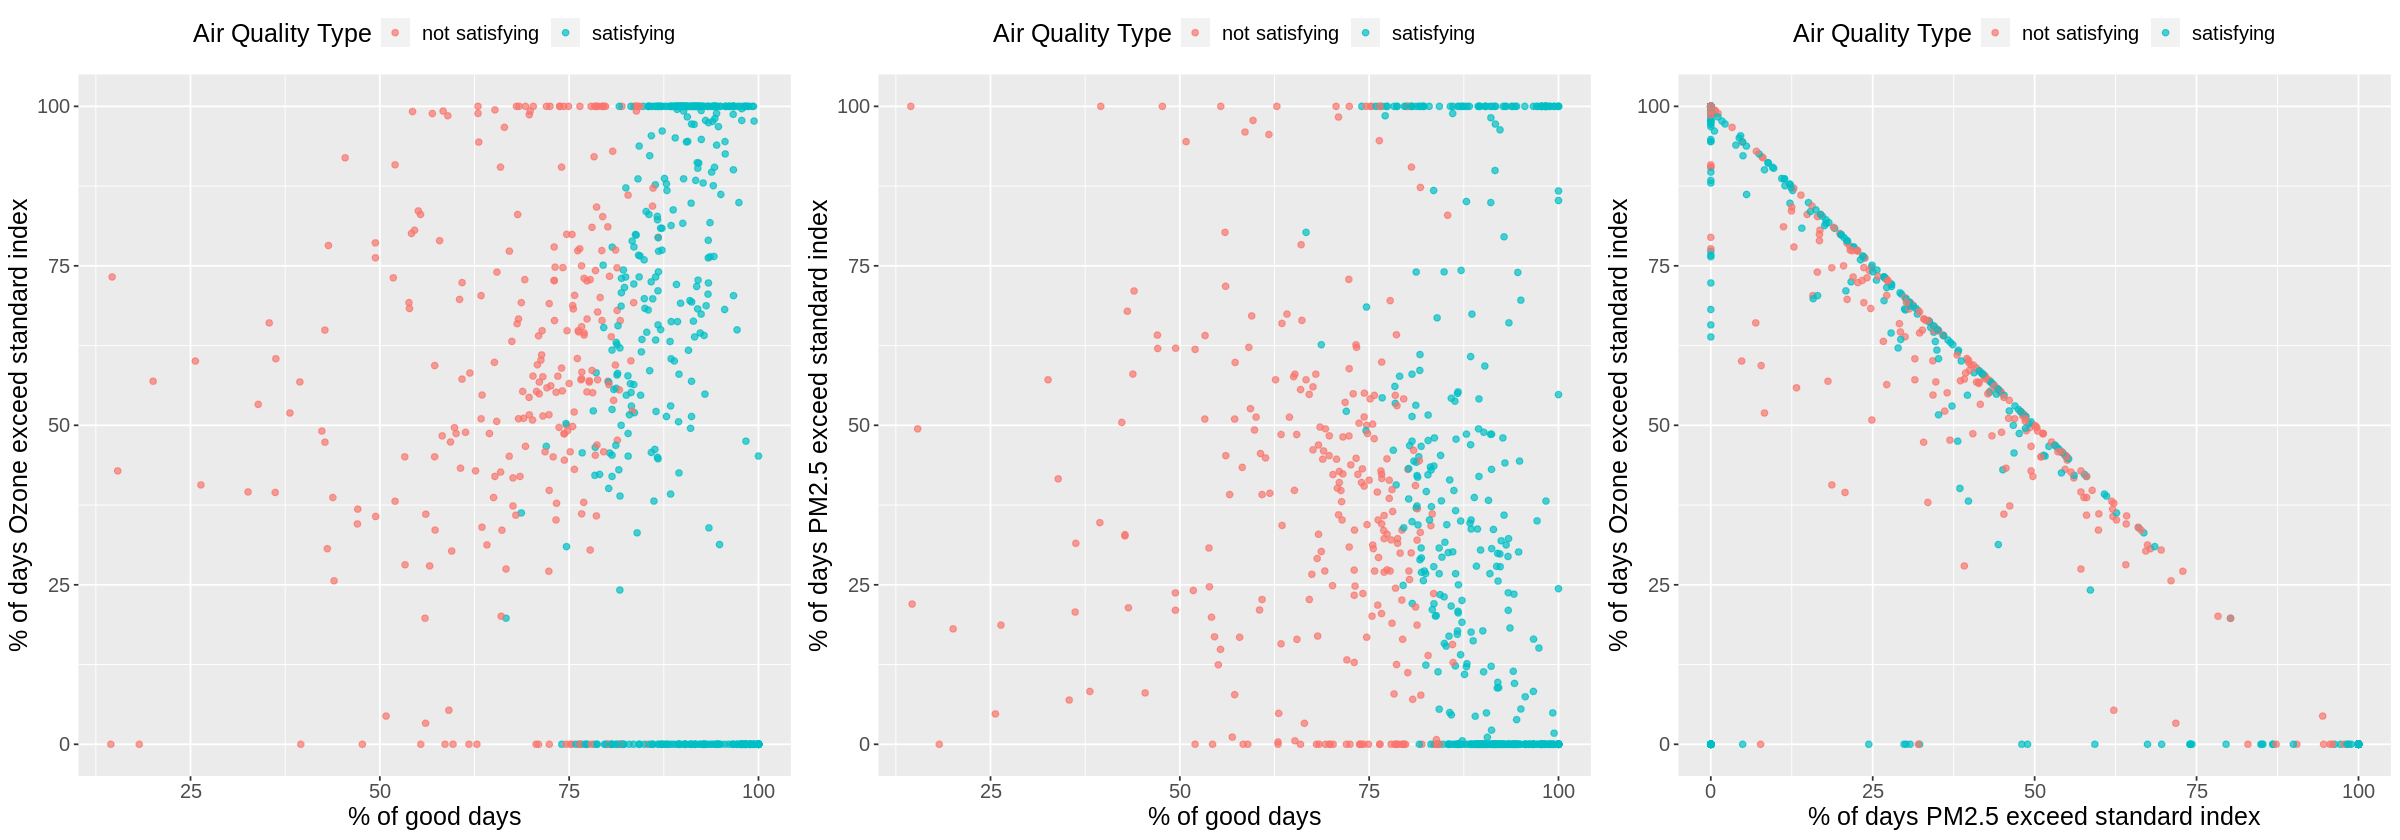

In [121]:
options(repr.plot.width = 20, repr.plot.height = 7)
train_plot1 <- ggplot(data = Air_quality_train,aes(x = per_good_days, y = per_days_Ozone)) +
    geom_point(aes(colour = air_quality_type), alpha = 0.7) +
    labs(colour = "Air Quality Type") +
    xlab("% of good days") + 
    ylab("% of days Ozone exceed standard index") +
    theme(text = element_text(size = 15), legend.position="top")

train_plot2 <- ggplot(data = Air_quality_train,aes(x = per_good_days, y = per_days_PM2.5)) +
    geom_point(aes(colour = air_quality_type), alpha = 0.7) +
    labs(colour = "Air Quality Type") +
    xlab("% of good days") + 
    ylab("% of days PM2.5 exceed standard index") +
    theme(text = element_text(size = 15), legend.position="top")

train_plot3 <- ggplot(data = Air_quality_train,aes(x = per_days_PM2.5, y = per_days_Ozone)) +
    geom_point(aes(colour = air_quality_type), alpha = 0.7) +
    labs(colour = "Air Quality Type") +
    xlab("% of days PM2.5 exceed standard index") + 
    ylab("% of days Ozone exceed standard index") +
    theme(text = element_text(size = 15),legend.position = "top")



    
plot_grid(train_plot1, train_plot2, train_plot3, ncol = 3)

## Method

## Expected outcomes and significance